In [66]:
%%capture

! pip install datasets transformers

# Load Dog-Food Dataset
Let's load a dataset for binary classification between `Dog` and `Food`.

In [67]:
from datasets import load_dataset

ds = load_dataset('sasha/dog-food')
ds

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 900
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2100
    })
})

Let's take a look at a random example from the dataset (say 100th). You can see each dataset sample consists of an image and the corresponding label as an integer.

In [68]:
ex = ds['train'][101]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x499 at 0x7FBB902F8490>,
 'label': 0}

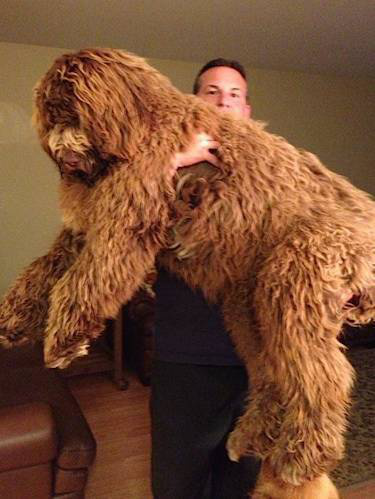

In [69]:
image = ex['image']
image

That's a big doggo! 🐶

Now although this dataset only contains two labels, it would be much easier to read the string representation of the integer labels.

In [70]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['dog', 'food'], id=None)

Using the indices and its corresponding label in string format, we can instantiate the `int2str` function of `ClassLabel`, allowing us to pass the integer representation of the class to look up the string label.

In [71]:
labels.int2str(ex['label'])

'dog'

Now let's explore our dataset a bit better. So far, we have only looked at one dog datapoint. Let's take a look at a few examples from both `dog` and `food` labels.

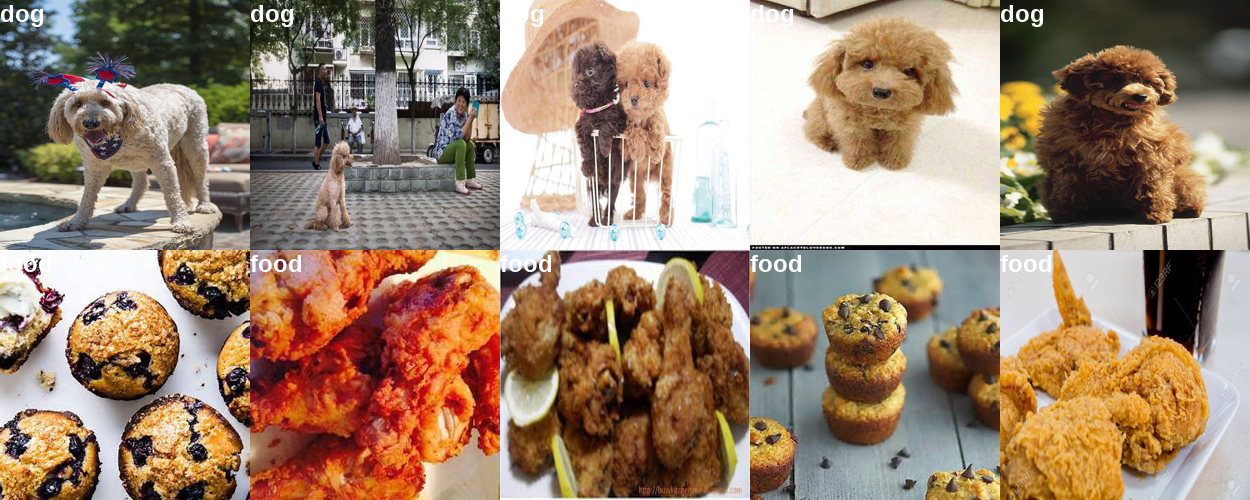

In [72]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1244, examples_per_class: int = 4, size=(250, 250)):
  w, h = size
  labels = ds['train'].features['label'].names
  grid = Image.new('RGB', size=(examples_per_class * w, 2 * h))
  draw = ImageDraw.Draw(grid)
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf", 24)

  for label_id, label in enumerate(labels):
    # filter by selected label, shuffle, then grab a number of samples
    ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

    # Plot label's examples
    for i, example in enumerate(ds_slice):
      image = example['image']
      idx = examples_per_class * label_id + i
      box = (idx % examples_per_class * w, idx // examples_per_class * h)
      grid.paste(image.resize(size), box=box)
      draw.text(box, label, (255, 255, 255), font=font)

  return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=5)

# Image Preprocessing
With previous steps, we gained a better understanding of our dataset.

Now it's time to set up the preprocessing of the input images. This step is crucial as the incorrect transformations not matching with the pre-trained model results in poor predictions.

So, we will be using the `ViTFeatureExtractor` already configured by the team that pretrained our model, [google/vit-base-batch16-224](https://huggingface.co/google/vit-base-patch16-224-in21k).

In [73]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [74]:
# print configuration of the downloaded feature extractor
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

We can call the feature extractor on an image by passing it in. Setting the `return_tensors=pt` will return `torch` tensors instead of the default numpy array.

In [75]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.0353, -0.0196, -0.0118,  ..., -0.0510, -0.0275, -0.0196],
          [-0.0275, -0.0353, -0.0196,  ..., -0.0510, -0.0431, -0.0667],
          [-0.0353, -0.0196, -0.0431,  ..., -0.0824, -0.0824, -0.0980],
          ...,
          [-0.2941, -0.3020, -0.3176,  ...,  0.0588,  0.0431,  0.0510],
          [-0.2549, -0.3020, -0.3020,  ...,  0.0431,  0.0510,  0.0667],
          [-0.2784, -0.2863, -0.2941,  ...,  0.0745,  0.0902,  0.0980]],

         [[-0.2941, -0.2784, -0.2706,  ..., -0.2863, -0.2706, -0.2627],
          [-0.2863, -0.2941, -0.2784,  ..., -0.2627, -0.2627, -0.2863],
          [-0.2941, -0.2784, -0.3020,  ..., -0.2784, -0.2784, -0.2941],
          ...,
          [-0.6863, -0.6941, -0.7098,  ..., -0.3412, -0.3569, -0.3490],
          [-0.6392, -0.6863, -0.6941,  ..., -0.3333, -0.3333, -0.3176],
          [-0.6549, -0.6627, -0.6706,  ..., -0.3176, -0.3020, -0.2941]],

         [[-0.5373, -0.5216, -0.5137,  ..., -0.4275, -0.4118, -0.4039],
          [-0

# Preprocessing for the Entire Dataset

In [76]:
# function to preprocess a single example
def process_example(example):
  inputs = feature_extractor(example['image'], return_tensors='pt')
  inputs['label'] = example['label']
  return inputs

Let's try calling this function on the first trianing example.

In [77]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[0.5608, 0.5922, 0.6078,  ..., 0.6627, 0.6706, 0.6627],
          [0.6627, 0.6941, 0.7333,  ..., 0.6863, 0.6784, 0.6627],
          [0.7098, 0.7725, 0.7961,  ..., 0.6941, 0.6627, 0.6392],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.6000, 0.6314, 0.6392,  ..., 0.7333, 0.7333, 0.7255],
          [0.6941, 0.7255, 0.7647,  ..., 0.7490, 0.7412, 0.7333],
          [0.7412, 0.8039, 0.8275,  ..., 0.7490, 0.7255, 0.7020],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.4275, 0.4510, 0.4824,  ..., 0.5294, 0.5451, 0.5608],
          [0.5373, 0.5843, 0.6314,  ..., 0.5294, 0.5216, 0.5294],
          [0.6235, 0.7020

Naturally, we would want to call this function to every datapoint in the dataset using `map`. However, doing so would result in a very slow computation, especially if you are using a large dataset.

Instead, we will use a transform to the dataset using the `process_example` function we have built. Transforms are applied to individual datapoints as we index them, saving time and computation.

First, we will need to update `process_example` function to take in a batch of data, as that is what `ds.with_transform expects`.

In [78]:
def transform(example_batch):
  # Turn a list of PIL images and turn them into pixel values
  inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

  # include the labels to the transformed inputs
  inputs['label'] = example_batch['label']

  return inputs

preprocessed_ds = ds.with_transform(transform)

In [79]:
# whenever an datapoint pixel values are called, transform will be applied in real time
preprocessed_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.5608,  0.5922,  0.6078,  ...,  0.6627,  0.6706,  0.6627],
          [ 0.6627,  0.6941,  0.7333,  ...,  0.6863,  0.6784,  0.6627],
          [ 0.7098,  0.7725,  0.7961,  ...,  0.6941,  0.6627,  0.6392],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.6000,  0.6314,  0.6392,  ...,  0.7333,  0.7333,  0.7255],
          [ 0.6941,  0.7255,  0.7647,  ...,  0.7490,  0.7412,  0.7333],
          [ 0.7412,  0.8039,  0.8275,  ...,  0.7490,  0.7255,  0.7020],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.4275,  0.4510,  0.4824,  ...,  0.5294,  0.5451,  0.5608],
          [ 0

# Training & Evaluation

Now we have to set up the training pipeline. We will utilize Hugging Face's Trainer. In order to do so, we need to do the following:

- Define a collate function
- Define an evaluation metric
- Load a pretrained checkpoint and correctly configure it before fine-tuning
- Define the training configuration

After fine-tuning the model, we will evaluate the trained model with the test set.

## Defining a collate function

Batches are a list of dictionaries, so we unpack them per key then stack them into batch tensors.

In [80]:
import torch

def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.tensor([x['label'] for x in batch])
  }

## Defining an evaluation metric
We use the `accuracy` metric from `datasets` by applying it on the model's predictions.

In [81]:
import numpy as np
from datasets import load_metric

metric = load_metric('accuracy')
def compute_metrics(p):
  return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now let's load the pre-trained model. We will configure it to create a classification head with two possible outputs. We will also add the `id2label` and `label2id` mappings.

In [82]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "dog",
    "1": "food"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "dog": "0",
    "food": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.25.1"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6

Let's define the training configuration.

In [97]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./vit-base-dog-food-v2",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

PyTorch: setting up devices


Now we can create the Trainer using everything we have previously built.

In [84]:
from transformers import Trainer

trainer = Trainer(
  model=model,
  args=training_args,
  data_collator=collate_fn,
  compute_metrics=compute_metrics,
  train_dataset=preprocessed_ds['train'],
  eval_dataset=preprocessed_ds['test'],
  tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [85]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2100
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 528
  Number of trainable parameters = 85800194


Step,Training Loss,Validation Loss,Accuracy
100,0.013000,0.027888,0.993333
200,0.024900,0.015219,0.995556
300,0.002200,0.012096,0.996667
400,0.039200,0.011456,0.997778
500,0.001400,0.006854,0.997778


***** Running Evaluation *****
  Num examples = 900
  Batch size = 8
Saving model checkpoint to ./vit-base-dog-food-v1/checkpoint-100
Configuration saved in ./vit-base-dog-food-v1/checkpoint-100/config.json
Model weights saved in ./vit-base-dog-food-v1/checkpoint-100/pytorch_model.bin
Image processor saved in ./vit-base-dog-food-v1/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 900
  Batch size = 8
Saving model checkpoint to ./vit-base-dog-food-v1/checkpoint-200
Configuration saved in ./vit-base-dog-food-v1/checkpoint-200/config.json
Model weights saved in ./vit-base-dog-food-v1/checkpoint-200/pytorch_model.bin
Image processor saved in ./vit-base-dog-food-v1/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 900
  Batch size = 8
Saving model checkpoint to ./vit-base-dog-food-v1/checkpoint-300
Configuration saved in ./vit-base-dog-food-v1/checkpoint-300/config.json
Model weights saved in ./vit-base-dog-food-v1

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 606228329GF
  train_loss               =      0.0245
  train_runtime            =  0:03:43.90
  train_samples_per_second =      37.515
  train_steps_per_second   =       2.358


In [86]:
metrics = trainer.evaluate(preprocessed_ds['test'])
trainer.log_metrics('eval', metrics)
trainer.save_metrics('eval', metrics)

***** Running Evaluation *****
  Num examples = 900
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9978
  eval_loss               =     0.0069
  eval_runtime            = 0:00:13.46
  eval_samples_per_second =     66.827
  eval_steps_per_second   =       8.39


In [87]:
model.config._name_or_path

'google/vit-base-patch16-224-in21k'

In [88]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [98]:
kwargs = {
    "model_name": "vit-base-dog-or-food",
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": "sasha/dog-food",
    "dataset_args": "image-classification",
    "tags": ['image-classification']
}

if training_args.push_to_hub:
  trainer.push_to_hub("vit-base-dog-food-v2", use_temp_dir=True, **kwargs)
else:
  trainer.create_model_card(**kwargs)

OSError: ignored